# Credit Card Fraud Detection Using Multivariate Gaussians

* Source: https://www.kaggle.com/code/hrao768/gaussian-distrib-for-anomaly-detection-f1-83/notebook
* Accessed: Jan 15, 2025
* Modified as needed

For training and evaluating Gaussian distribution algorithms, we are going to split the train, cross validation and test data sets using below ratios.

    1) Train:  60% of the Genuine records (y=0), no Fraud records(y=1). So the training set will not have a label as well.
    
    2) CV:  20% of the Genuine records (y=0), 50% of the Fraud records(y=1)
    
    3) Test: Remaining 20% of the Genuine records(y=0), Remaining 50% of the Fraud records(y=1)



Procedure for anomaly detection:

    1) Fit the model p(x) on training set
    
    2) On cross validation/test data, predict
    
        y = 1 if p(x) < epsilon (anomaly)
        
        y = 0 if p(x) >= epsilon (normal)
        
    3) We use cross validation to choose parameter epsilon using the evaluation metrics Preceion/Recall, F1-score.
    


We could use couple of Gaussian distribution models for training anomaly detection.

    1) Gaussian (Normal) Distribution - the normal distribution is parametrized in terms of the mean and the variance.
    
    2) Multivariate Normal Distribution - The probability density function for multivariate_normal is parametrized in terms of the mean and the covariance.

Algorithm Selection:

    1) For this dataset, we are going to use multivariate normal probability density function, since it automatically generates the relationships (correlation) between variables to calculate the probabilities. So we don't need to derive new features. As the features are outcome of PCA, it is difficult for us to understand the relationship between these features. 

    2) However multivariate normal probability density function is computationally expensive compared to normal Gaussian probability density function. On very large datasets, we might have to prefer Gaussian probability density function instead of multivariate normal probability density function to speed up the process and do feature engineering.


Feature Selection:

    1) Features that we choose for these algorithms have to be normally distributed. Otherwise we need to transform the features to normal distribution using log, sqrt etc.

    2) Choose features that might take on unusually large or small values in the event of an anomaly. We looked at the distribution in the beginning using distplot. So it is wise to choose features which have completely different distribution for fraud records compared to genuine records.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score

from collections import Counter

from scipy.stats import norm, multivariate_normal

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [3]:
def Print_Accuracy_Scores(y,y_pred):
    print("F1 Score: ", f1_score(y,y_pred))
    print("Precision Score: ", precision_score(y,y_pred))
    print("Recall Score: ", recall_score(y,y_pred))

In [4]:
#Loading Dataset
# UNCOMMENT ONE

url = "https://github.com/AET-CS/aet-cs.github.io/blob/main/white/ML/data/creditcard.csv"

# cc_dataset = pd.read_csv(url=url)
cc_dataset = pd.read_csv("creditcard.csv")

In [5]:
cc_dataset.shape

(284807, 31)

In [6]:
cc_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
cc_dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
#Code for checking if any feature has null values. Here the output confirms that there are no null values in this data set.
cc_dataset.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [11]:
#Counts for each class in the dataset. As you can see, we have only 492 (0.17%) fraud cases out of 284807 records. Remaining 284315 (99.8%) of the records belong to genuine cases.
#So the dataset is clearly imbalanced!
cc_dataset['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

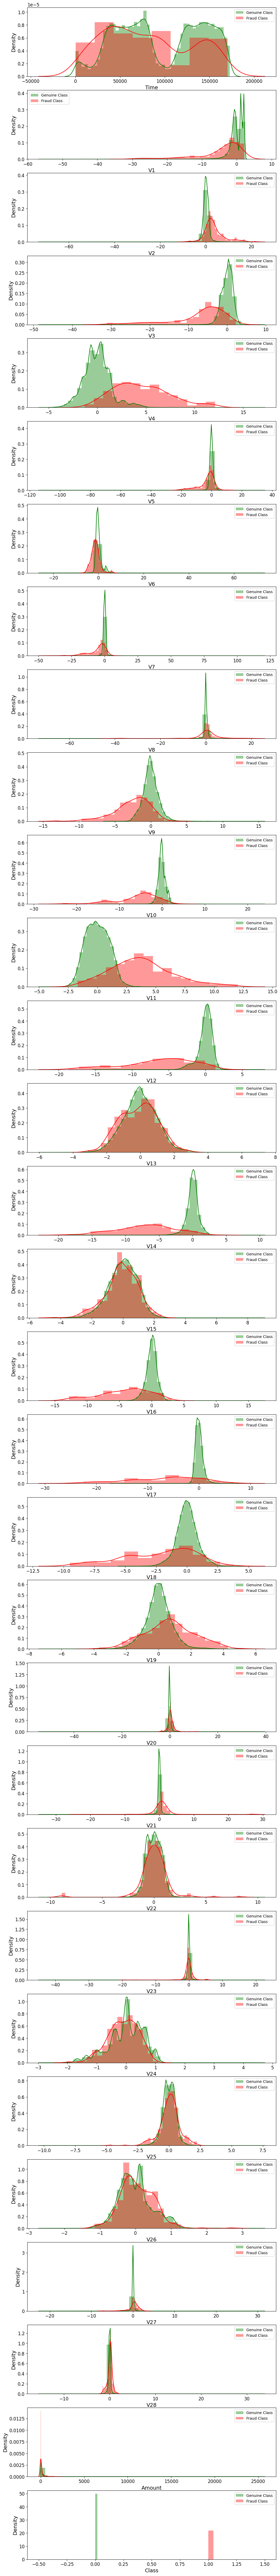

In [12]:
#Data Visualization for checking the distribution for Genuine cases & Fraud cases for each feature
v_features = cc_dataset.columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31,1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sns.distplot(cc_dataset[col][cc_dataset['Class']==0],color='g',label='Genuine Class')
    sns.distplot(cc_dataset[col][cc_dataset['Class']==1],color='r',label='Fraud Class')
    ax.legend()
plt.show()

Feature selection: 
    1) We can see Normal Distribution of anomalous transactions (class = 1) is matching with Normal Distribution of genuine transactions (class = 0) for V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8' features. It is better to delete these features as they may not be useful in finding anomalous records.
    2) Time is also not useful variable since it contains the seconds elapsed between the transaction for that record and the first transaction in the dataset. So the data is in increasing order always.

In [13]:
cc_dataset.drop(labels = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8','Time'], axis = 1, inplace=True)
cc_dataset.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class'],
      dtype='object')

Below features doesn't have the same distribution for both genuine & fraud records. However distribution for fraud records is not unusual as well.
So I'll delete these features as well, since the features with unusual behavior for Fraud records will be most useful in anomaly detection algorithm.

In [14]:
cc_dataset.drop(labels = ['V1','V2','V5','V6','V7','V21','Amount'], axis = 1, inplace=True)
cc_dataset.columns

Index(['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18',
       'V19', 'Class'],
      dtype='object')

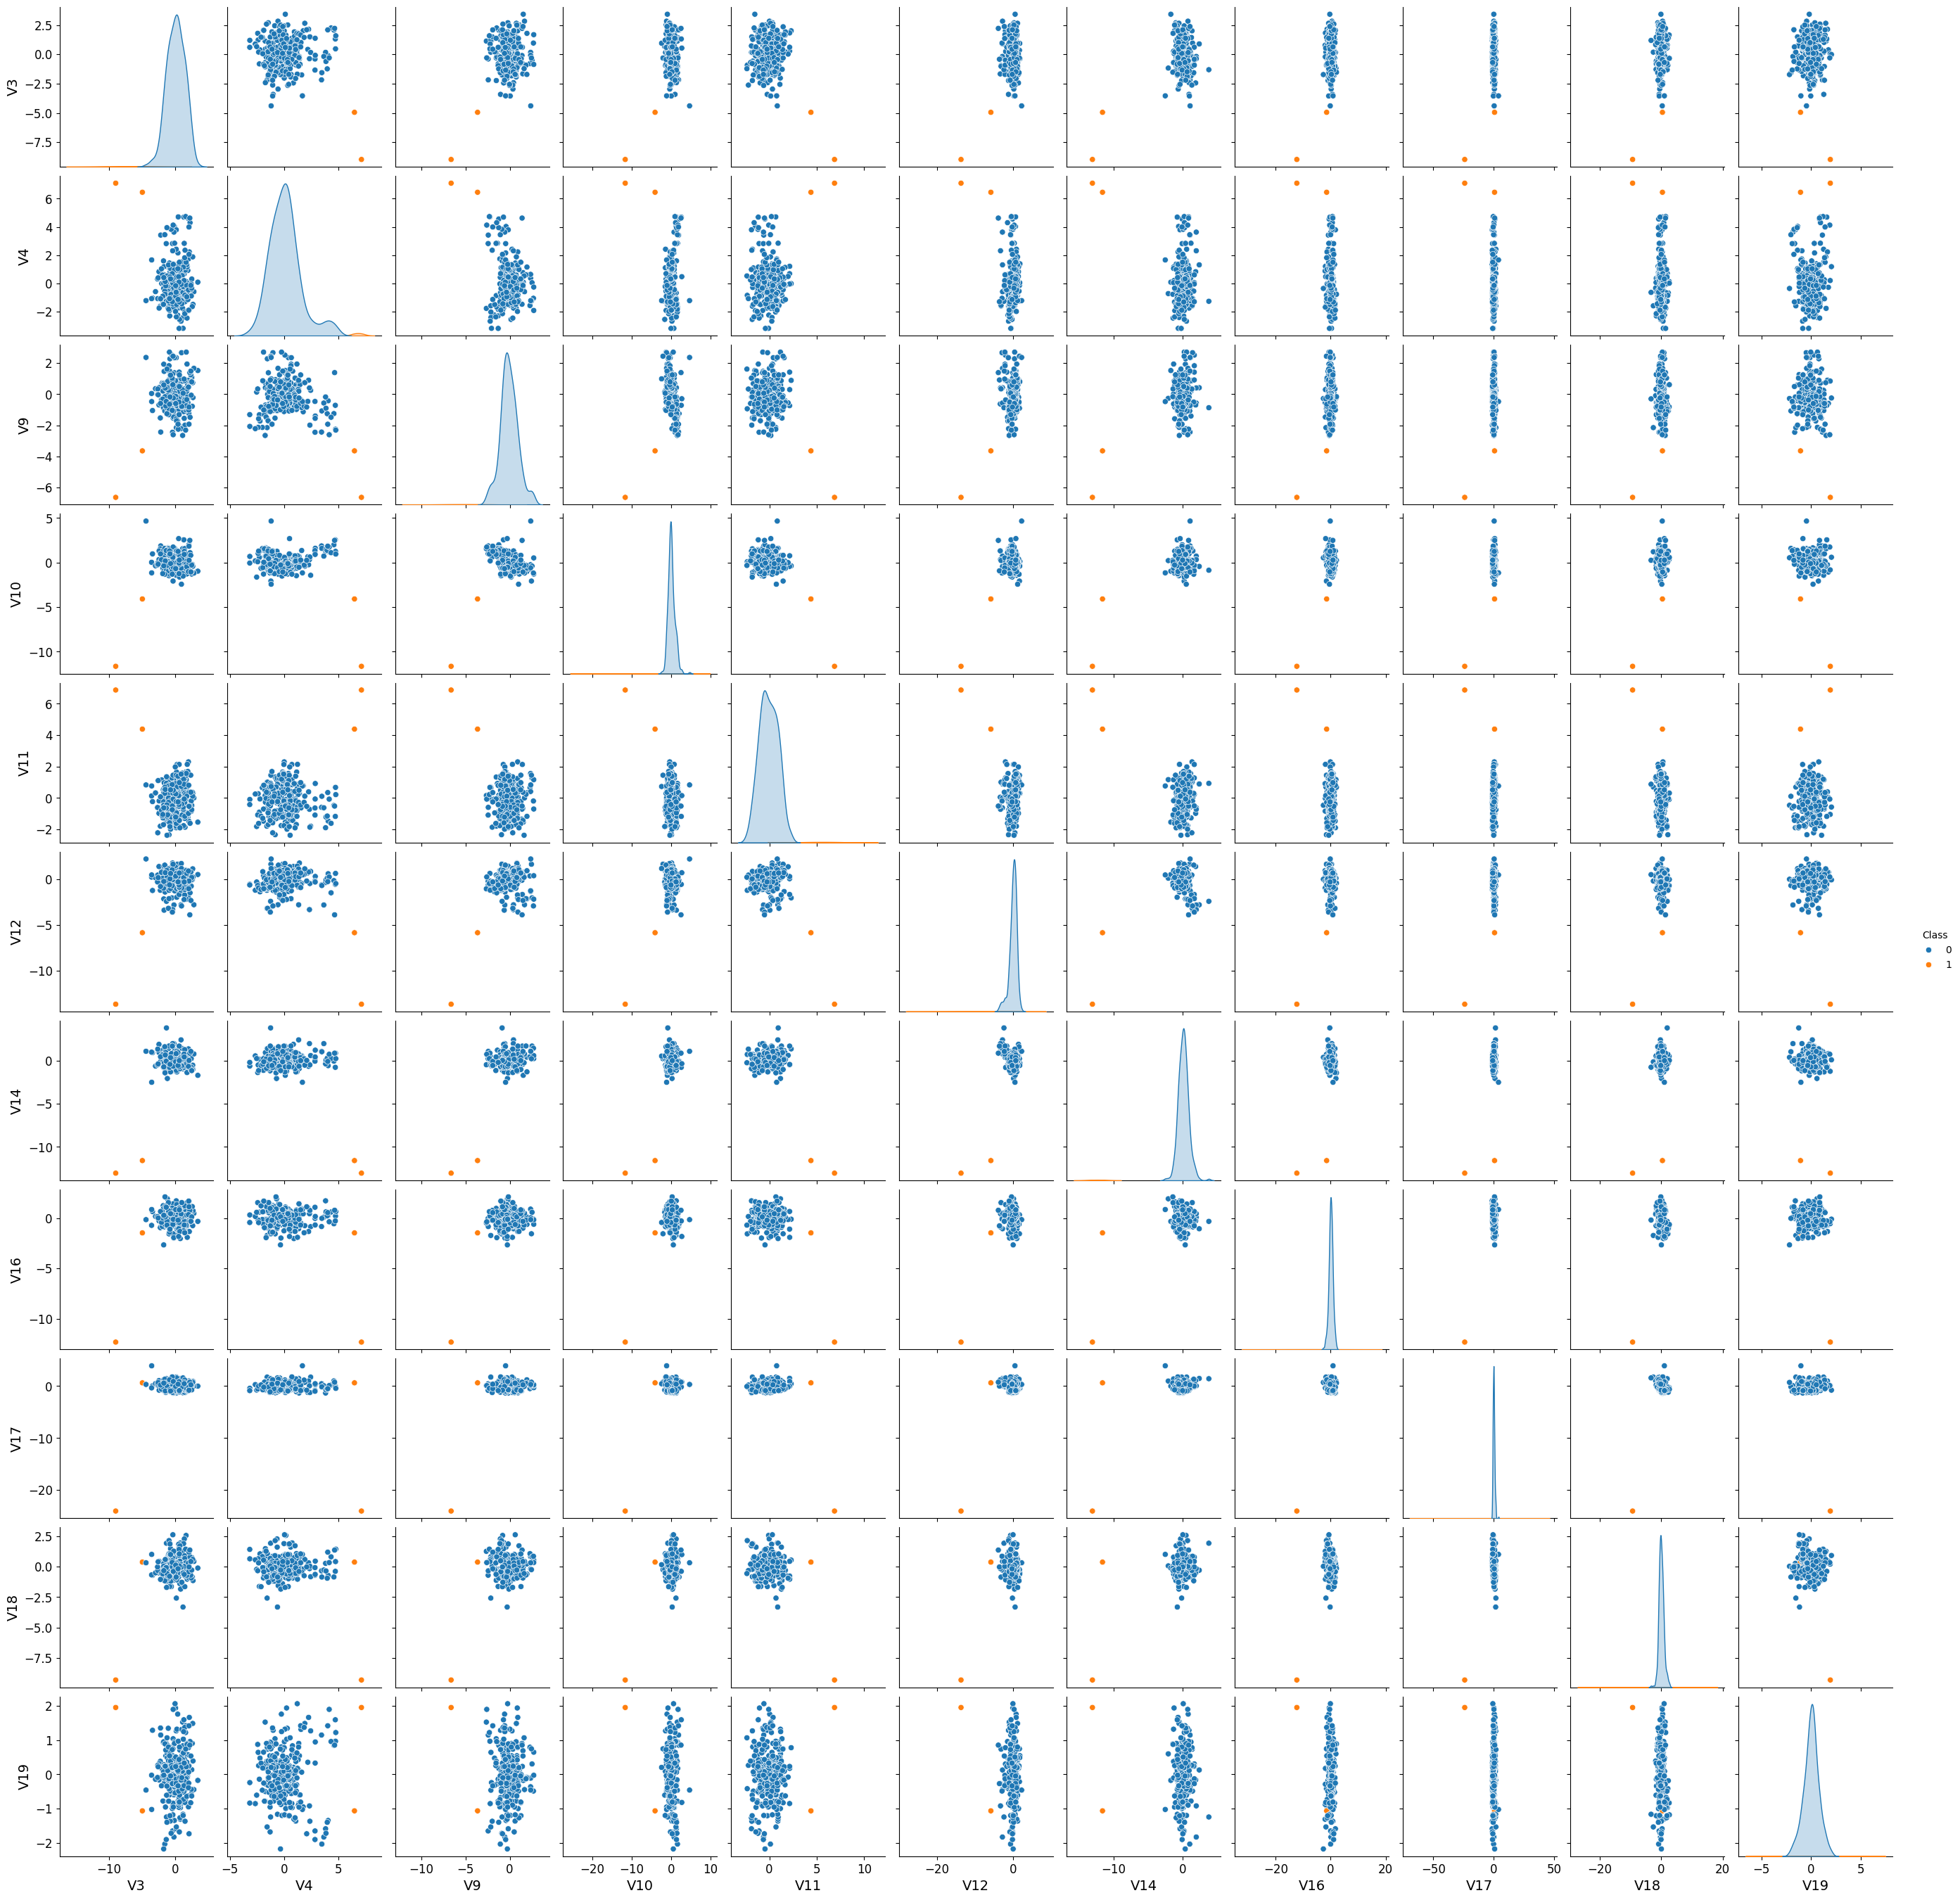

In [15]:
#Visualization to understand the relationship between features and also data pattern using pair plot from seaborn
cc_subset = cc_dataset.sample(frac=0.001)
g = sns.pairplot(cc_subset,hue="Class",diag_kind='kde')

(Plot omitted. It takes a long time and doesn't reveal much)

There is not much insight form the pairplot except that most of features have clear separation for fraud records versus genuine records. We can notice that distribution of fraud records is quite different compared to genuine records in the diagonal kde plots. All the features looks to be normally distributed. So we can train the Multivariate Guassian Distribution algorthm using the original features.

In [16]:
#Method for selecting epsilon with best F1-score
def SelectThresholdByCV_Anomaly(probs,y):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    precision =0
    recall=0
    best_recall = 0
    best_precision = 0
    
    #epsilons = sorted(np.unique(probs))
    #print(epsilons)
    epsilons = np.arange(0,1,0.01)
    
    precisions=[]
    recalls=[]
    for epsilon in epsilons:
        predictions = (probs < epsilon)
        f = f1_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        #print("Theshold {0},Precision {1},Recall {2}".format(epsilon,precision,recall))
          
        if f > best_f1:
            best_f1 = f
            best_precision = precision
            best_recall = recall
            best_epsilon = epsilon
        
        precisions.append(precision)
        recalls.append(recall)

    #Precision-Recall Trade-off
    plt.plot(epsilons,precisions,label='Precision')
    plt.plot(epsilons,recalls,label='Recall')
    plt.xlabel("Epsilon")
    plt.title('Precision Recall Trade Off')
    plt.legend()
    plt.show()

    print ('Best F1 Score %f' %best_f1)
    print ('Associated Precision Score %f' %best_precision)
    print ('Associated Recall Score %f' %best_recall)
    print ('Associated Epsilon', best_epsilon)
    return best_epsilon

In [17]:
#Method for calculating parameters Mu & Co-variance
def estimateGaussian(data):
    mu = np.mean(data,axis=0)
    sigma = np.cov(data.T)
    return mu,sigma

In [18]:
#Method for implementing multivariate gaussian distribution pdf, scaled
def MultivariateGaussianDistribution(data,mu,sigma):
    p = multivariate_normal.pdf(data, mean=mu, cov=sigma)
    p_transformed = np.power(p,1/100) #transformed the probability scores by p^1/100 since the values are very low (up to e-150)
    return p_transformed

In [20]:
genuine_data = cc_dataset[cc_dataset['Class']==0]
fraud_data = cc_dataset[cc_dataset['Class']==1]

# optionally reduce data for speed
# genuine_data = genuine_data.sample(frac=1, random_state=42)
# fraud_data = fraud_data.sample(frac=1.0)

In [21]:
#Split Genuine records into train & test - 60:40 ratio
genuine_train,genuine_test = train_test_split(genuine_data,test_size=0.4,random_state=0)
print(genuine_train.shape)
print(genuine_test.shape)

(170589, 12)
(113726, 12)


In [22]:
#Split 40% of Genuine Test records into Cross Validation & Test again (50:50 ratio)
genuine_cv,genuine_test = train_test_split(genuine_test,test_size=0.5,random_state=0)
print(genuine_cv.shape)
print(genuine_test.shape)

(56863, 12)
(56863, 12)


In [23]:
#Split Fraud records into Cross Validation & Test (50:50 ratio)
fraud_cv,fraud_test = train_test_split(fraud_data,test_size=0.5,random_state=0)
print(fraud_cv.shape)
print(fraud_test.shape)

(246, 12)
(246, 12)


In [24]:
#Drop Y-label from Train data
train_data = genuine_train.drop(labels='Class',axis=1)
print(train_data.shape)

(170589, 11)


In [25]:
#Cross validation data
cv_data = pd.concat([genuine_cv,fraud_cv])
cv_data_y = cv_data['Class']
cv_data.drop(labels='Class',axis=1,inplace=True)
print(cv_data.shape)

(57109, 11)


In [26]:
#Test data
test_data = pd.concat([genuine_test,fraud_test])
test_data_y = test_data['Class']
test_data.drop(labels='Class',axis=1,inplace=True)
print(test_data.shape)

(57109, 11)


In [ ]:
#StandardScaler – Feature scaling is not required since all the features are already standardized via PCA
#sc = StandardScaler()
#train_data = sc.fit_transform(train_data)
#cv_data = sc.transform(cv_data)
#test_data = sc.transform(test_data)

In [27]:
#Find out the parameters Mu and Covariance for passing to the probability density function
mu,sigma = estimateGaussian(train_data)

In [30]:
mu

V3     0.010417
V4    -0.004144
V9     0.005154
V10    0.010192
V11   -0.008149
V12    0.008858
V14    0.012926
V16    0.006877
V17    0.011787
V18    0.003497
V19   -0.002516
dtype: float64

In [31]:
#Multivariate Gaussian distribution - This calculates the probability for each record.
p_train = MultivariateGaussianDistribution(train_data,mu,sigma)
print(p_train.mean())
print(p_train.std())
print(p_train.max())
print(p_train.min())

0.8619974422026009
0.046138762612606056
0.90419793993761
0.0


In [32]:
p_train

array([0.83161594, 0.89276287, 0.87744834, ..., 0.88820903, 0.85364518,
       0.84969703], shape=(170589,))

In [33]:
cv_data.shape, mu.shape

((57109, 11), (11,))

In [34]:
#Calculate the probabilities for cross validation and test records by passing the mean and co-variance matrix derived from train data
p_cv = MultivariateGaussianDistribution(cv_data,mu,sigma)
p_test = MultivariateGaussianDistribution(test_data,mu,sigma)

In [35]:
print(p_cv.mean())
print(p_cv.std())
print(p_cv.max())
print(p_cv.min())

0.8593021310754893
0.0651313415260517
0.9041592459720597
0.0


In [36]:
#Calculate the probabilities for cross validation and test records by passing the mean and co-variance matrix derived from train data
pf_cv = MultivariateGaussianDistribution(fraud_cv.drop('Class',axis=1),mu,sigma)

In [37]:
print(pf_cv.mean())
print(pf_cv.std())
print(pf_cv.max())
print(pf_cv.min())

0.1983896701248922
0.2927223194134566
0.8943011321467343
0.0


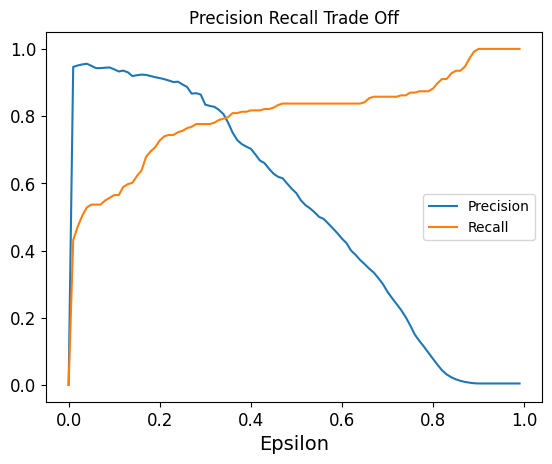

Best F1 Score 0.820961
Associated Precision Score 0.886792
Associated Recall Score 0.764228
Associated Epsilon 0.26


In [55]:
#Let us use cross validation to find the best threshold where the F1 -score is high
eps_optimal = SelectThresholdByCV_Anomaly(p_cv,cv_data_y)

In [39]:
#CV data - Predictions
pred_cv= (p_cv < eps_optimal)
Print_Accuracy_Scores(cv_data_y, pred_cv)

F1 Score:  0.8209606986899564
Precision Score:  0.8867924528301887
Recall Score:  0.7642276422764228


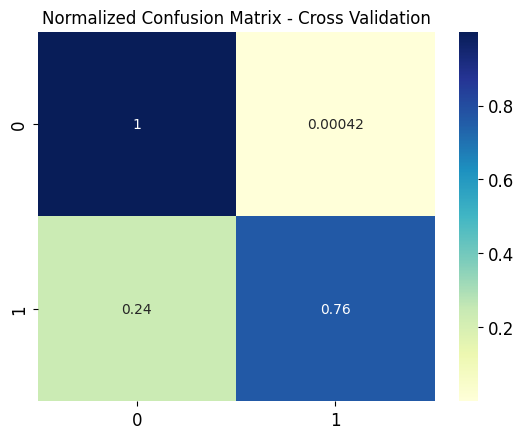

In [43]:
#Confusion matrix on CV
cnf_matrix = confusion_matrix(cv_data_y,pred_cv)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum 
sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True);
plt.title("Normalized Confusion Matrix - Cross Validation");

(These numbers in this paragraph and after will vary...)

Please notice that False negatives are around 24%. I tried to reduce false negatives & improve recall score by increasing the epsilon. I was successful in bringing the recall above 80%, however precsion is going down to 70% pretty quickly. Hence I decided to choose the epsilon with best f1-score, i.e: 0.2425

In [47]:
#Test data - Check the F1-score by using the best threshold from cross validation
pred_test = (p_test < eps_optimal)
Print_Accuracy_Scores(test_data_y,pred_test)

F1 Score:  0.8307692307692308
Precision Score:  0.9043062200956937
Recall Score:  0.7682926829268293


Text(0.5, 1.0, 'Normalized Confusion Matrix - Test data')

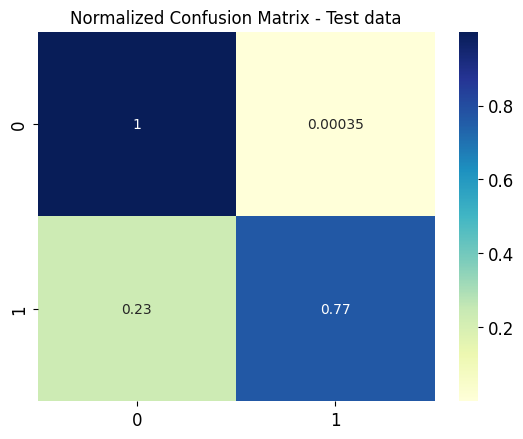

In [48]:
cnf_matrix = confusion_matrix(test_data_y, pred_test)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum 
sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Test data")

Conclusion: Anomaly detection algorthm has provided decent results with F1-score of 83. We can improve recall & thus f1-score further by deriving new features based on the business knowledge. Since the features are transformed from PCA output, we couldn't understand their purpose and do feature engineering.